In [10]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point

import pylab as plt
import os

import requests
try:
    s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
    plt.rcParams.update(s)
except: 
    pass

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
PARQA = os.getenv('PARQA')

## Calls to Districts

In [17]:
# calls = pd.read_csv(PARQA + 'data/311/MatchedCalls.cav', index_col=0)

In [ ]:
calls.head()

In [6]:
callsByDistr = pd.DataFrame(calls.parkDistrict.value_counts()).reset_index().rename(columns={'parkDistrict':'calls',
                                                                                             'index':'parkDistrict'})

In [7]:
districts = gp.read_file(PARQA + 'data/Districts/Districts_tmp.geojson')

In [8]:
districts.head(2)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,...",0
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ...",1


In [9]:
districtsAll = districts.merge(callsByDistr, how='left', left_on='SYSTEM',right_on='parkDistrict' )
                           

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,parkDistrict,calls
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,...",0,M-01,1126
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ...",1,M-02,1373


In [13]:
districtsAll.sort_values('calls', ascending=0).head(5) 

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,parkDistrict,calls,calls_normalised
7,None,M,164,8,3.830553e+07,32711.130377,M-13,"POLYGON ((995706.8963655531 230733.0110245645,...",7,M-13,3949,0.000103
61,None,M,"107, 109","6, 7, 9",1.627452e+07,49244.093392,M-14,"POLYGON ((988529.7433970571 225891.3002355546,...",61,M-14,3756,0.000231
65,None,M,103,"1, 2",4.339118e+07,30121.257864,M-03,"POLYGON ((986756.3256840557 197828.4469125569,...",65,M-03,3037,0.000070
60,None,M,112,"7, 10",6.952111e+07,56221.985932,M-12,"POLYGON ((998064.6764268875 243352.0304058939,...",60,M-12,2716,0.000039
21,None,B,301,"35, 33, 34",1.354542e+08,50817.429779,B-01,"POLYGON ((1005885.061048552 197715.4707605541,...",21,B-01,2670,0.000020


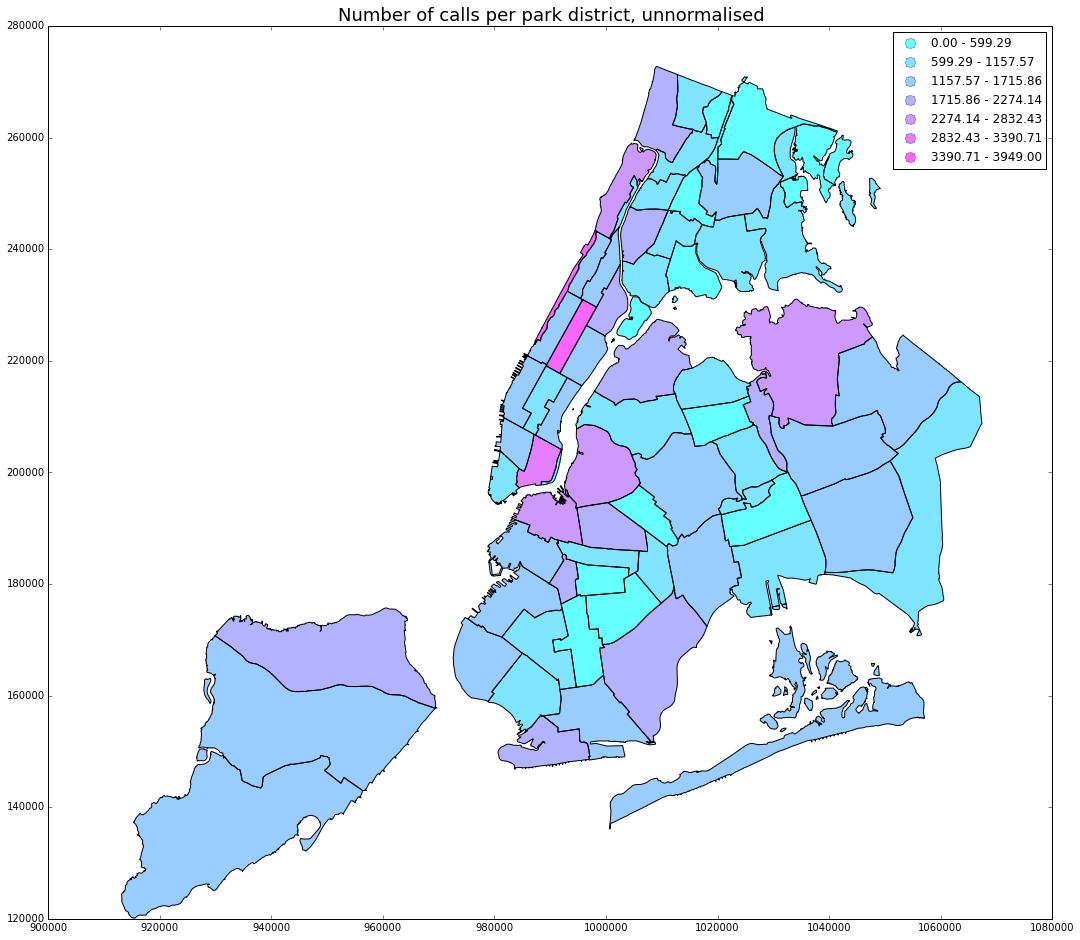

In [17]:
districtsAll.plot(figsize=(18,18), scheme='equal_interval', alpha=0.6, k=7, legend=True, column='calls', colormap='cool');
plt.title('Number of calls per park district, unnormalised',fontsize=18);
plt.legend()
plt.savefig(PARQA + 'parqa/311/img/map1.png')


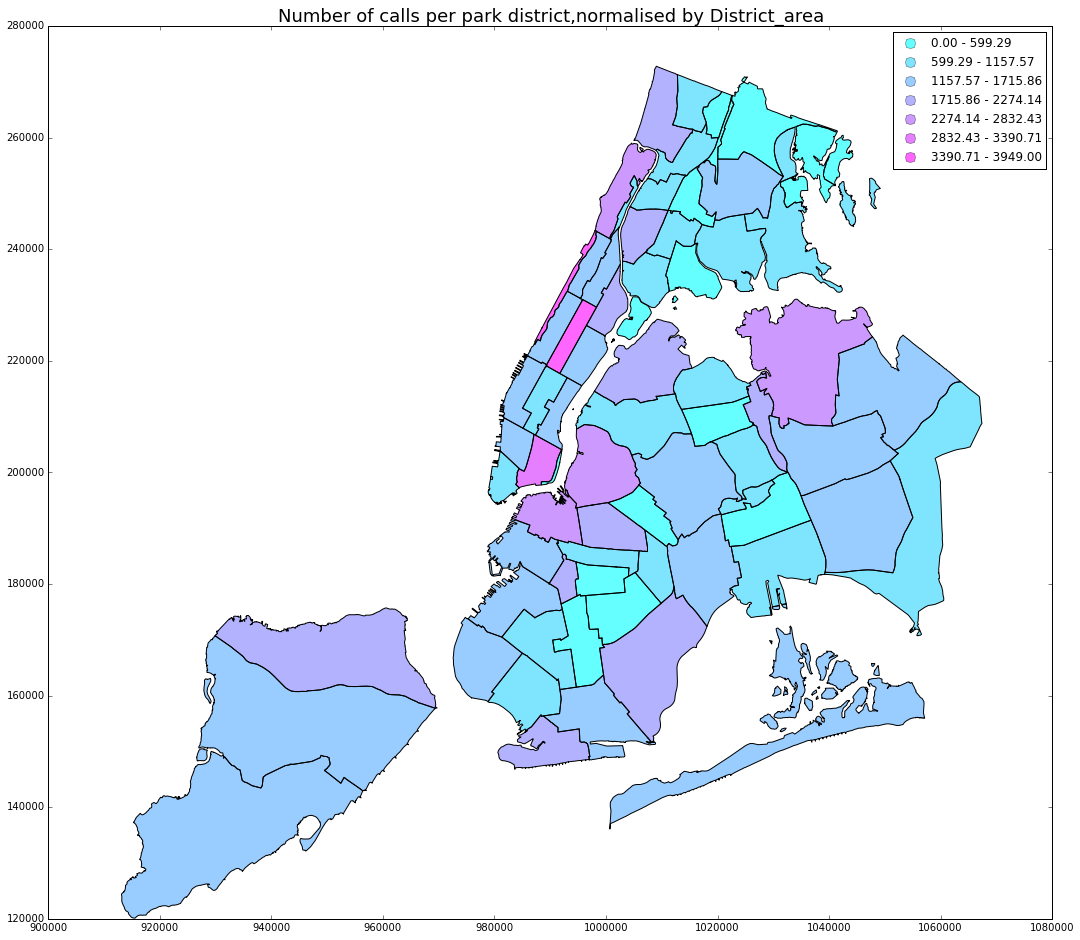

In [18]:
# now using shape area: need to calculate parks area per district.
districtsAll['calls_normalised'] = districtsAll['calls']/districtsAll['SHAPE_Area']
districtsAll.plot(figsize=(18,18), scheme='equal_interval', alpha=0.6, k=7, legend=True, column='calls', colormap='cool');

plt.title('Number of calls per park district,normalised by District_area',fontsize=18);
plt.savefig(PARQA + 'parqa/311/img/map2.png')

## Mapping Pike Calls

In [28]:
distr = gp.read_file(PARQA +'data/distr.json')

In [4]:
calls = pd.read_csv(PARQA + 'data/311/311_all_full.csv', encoding='utf8')

/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8,17,38,39,40,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
calls = calls[calls.Agency == 'DPR']
calls['Created Date'] = pd.to_datetime(calls['Created Date'])

In [9]:
geocalls = calls[pd.notnull(calls.Latitude)]

In [18]:
def toGeoDataFrame(df, lat='Latitude',lon='Longitude'):
    '''dataframe to geodataframe'''
    df['geometry'] = df.apply(lambda z: Point(z[lon], z[lat]), axis=1)
    df = gp.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326', 'no_defs': True}
    return df 

In [19]:
geocalls = toGeoDataFrame(geocalls)

In [36]:
geocalls = geocalls.to_crs(epsg=2236)
distr = distr.to_crs(epsg=2236)

In [42]:
geocalls['Created Date'].dt.year.value_counts()

2012    87850
2010    80006
2011    67129
2014    62407
2013    55134
2015    50416
Name: Created Date, dtype: int64

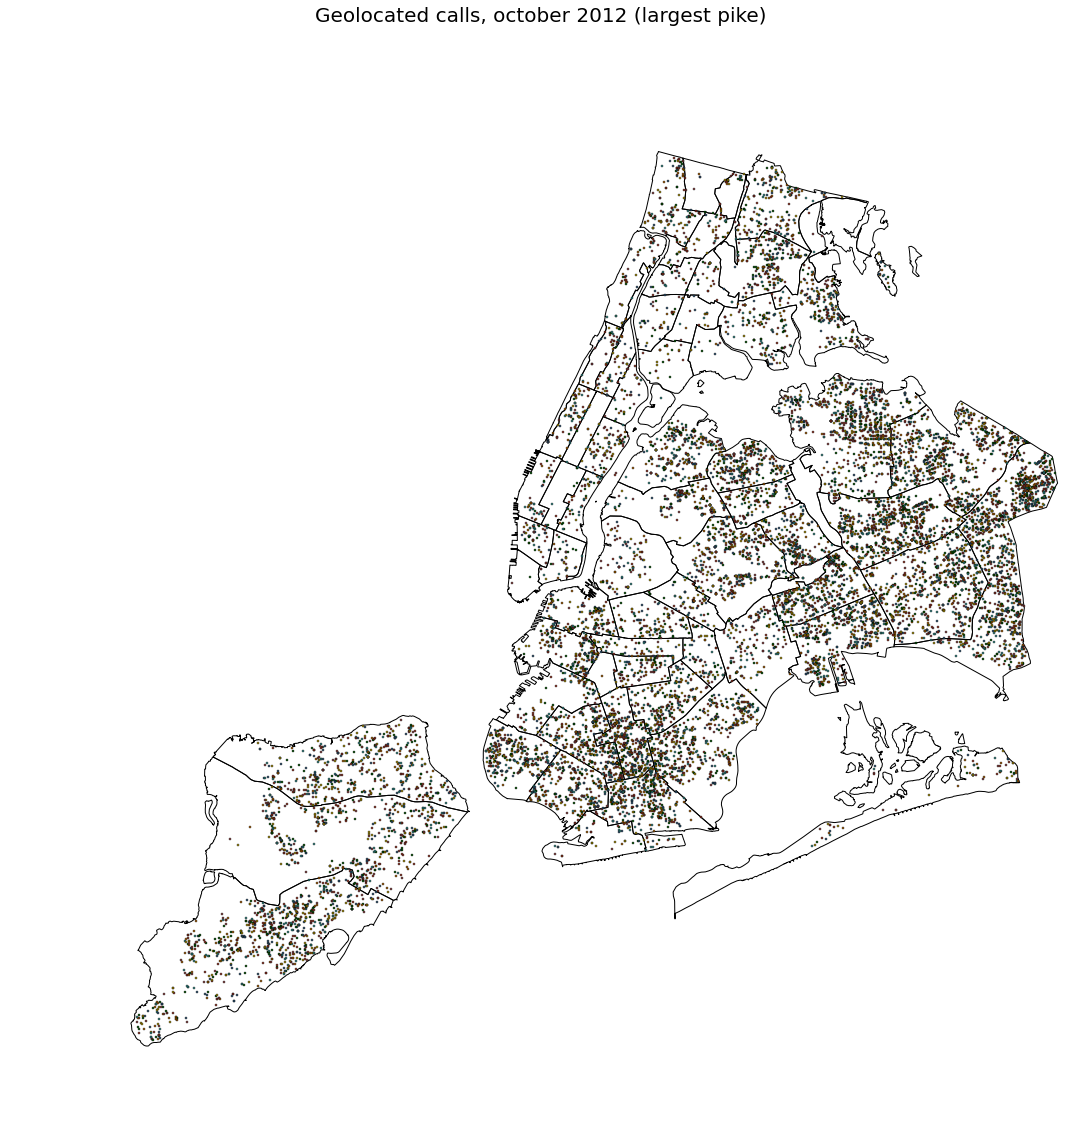

In [65]:
fig, ax = plt.subplots(figsize=(18,18))

distr.plot(axes=ax, column='m', alpha=0.0)
geocalls[(geocalls['Created Date'].dt.year==2012)&(geocalls['Created Date'].dt.month==10)].plot(axes=ax, column='Complaint Type',size=100, alpha=.1, colormap='Greens')

fig.suptitle('Geolocated calls, october 2012 (largest pike)', fontsize=20)
ax.set_axis_off()
plt.savefig(PARQA + 'parqa/311/img/calls2012_10.png')

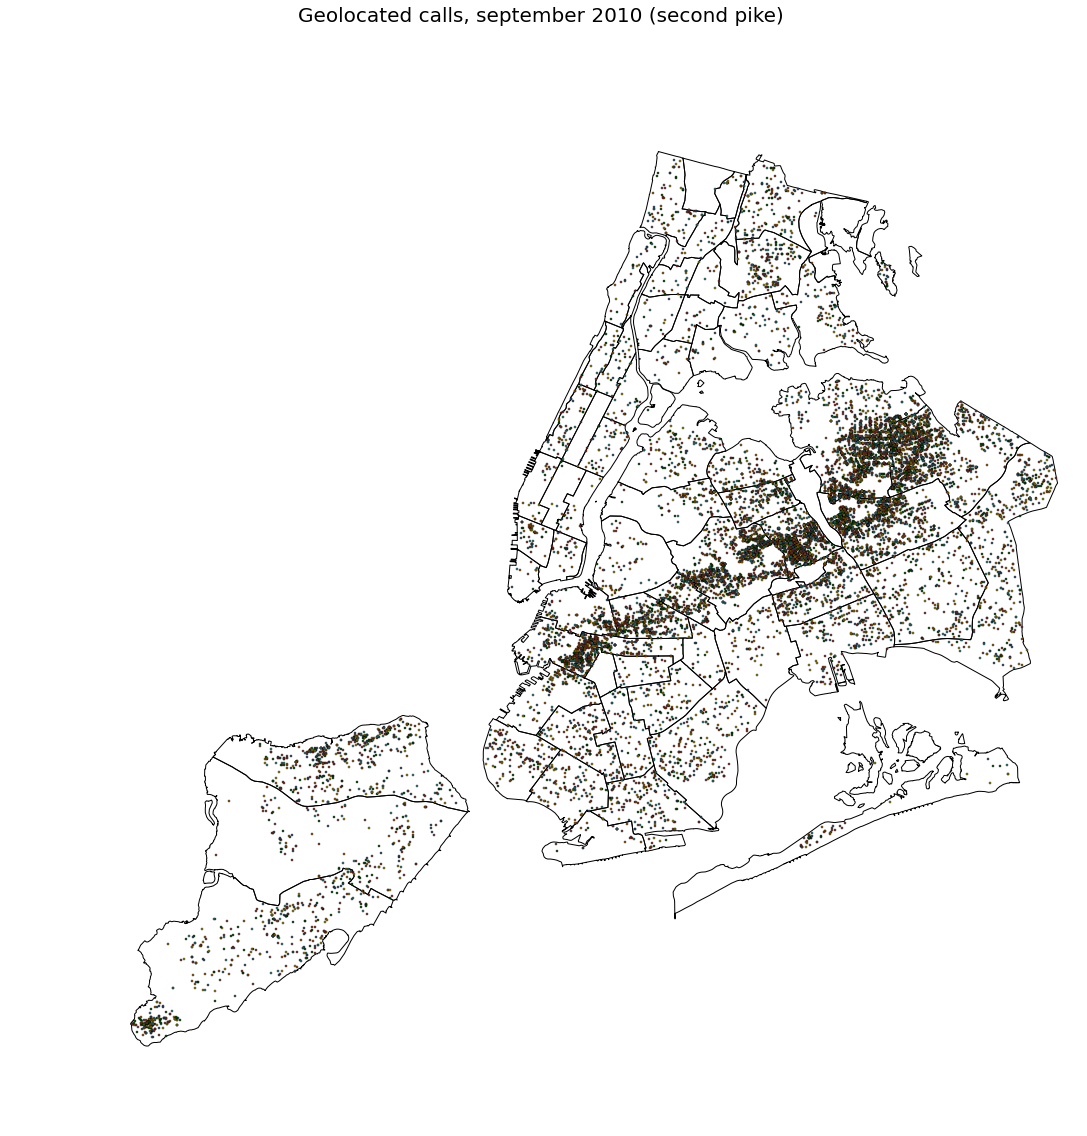

In [74]:
fig, ax = plt.subplots(figsize=(18,18))

distr.plot(axes=ax, column='m', alpha=0.0)
geocalls[(geocalls['Created Date'].dt.year==2010)&(geocalls['Created Date'].dt.month==9)].plot(axes=ax, column='Complaint Type',size=100, alpha=.1, colormap='Greens')

fig.suptitle('Geolocated calls, september 2010 (second pike)', fontsize=20)
ax.set_axis_off()
plt.savefig(PARQA + 'parqa/311/img/calls2010_09.png')

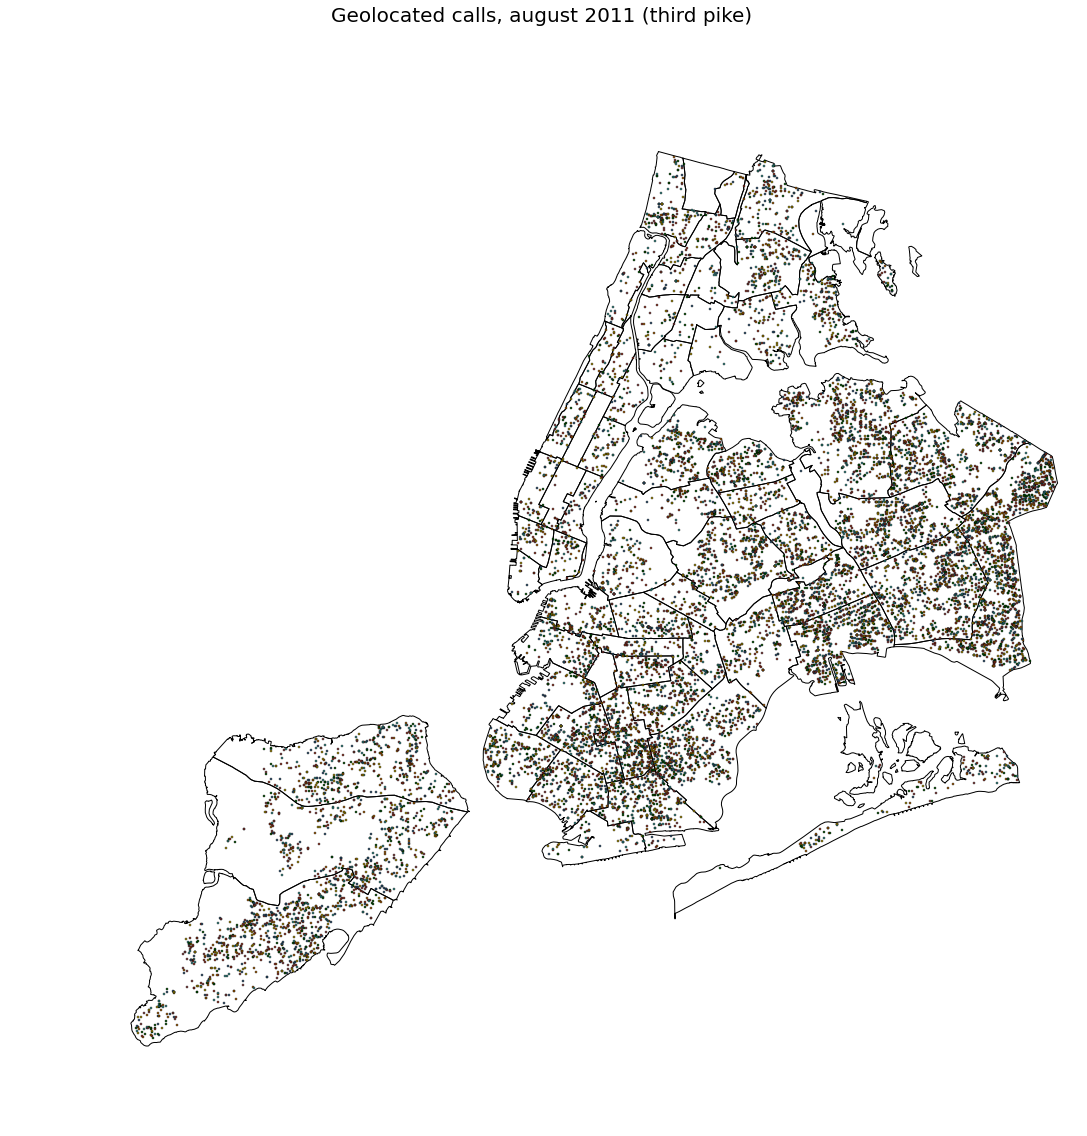

In [79]:
fig, ax = plt.subplots(figsize=(18,18))

distr.plot(axes=ax, column='m', alpha=0.0)
geocalls[(geocalls['Created Date'].dt.year==2011)&(geocalls['Created Date'].dt.month==8)].plot(axes=ax, column='Complaint Type',size=100, alpha=.1, colormap='Greens')

fig.suptitle('Geolocated calls, august 2011 (third pike)', fontsize=20)
ax.set_axis_off()
plt.savefig(PARQA + 'parqa/311/img/calls2011_08.png')

In [51]:
geocalls[(geocalls['Created Date'].dt.year==2012)&(geocalls['Created Date'].dt.month==10)]['Complaint Type'].value_counts()

Damaged Tree                     12990
Overgrown Tree/Branches           1357
Root/Sewer/Sidewalk Condition      819
Dead Tree                          636
Maintenance or Facility            216
Illegal Tree Damage                104
Animal in a Park                    40
Violation of Park Rules             24
Name: Complaint Type, dtype: int64

In [76]:
geocalls[(geocalls['Created Date'].dt.year==2012)&(geocalls['Created Date'].dt.month==10)]['Resolution Description'].value_counts()

The Department of Parks and Recreation has corrected the condition.                                                                                                                                                                                                   6795
The condition was inspected and it was determined that no work order was necessary. The condition will not be inspected again for at least 90 days.                                                                                                                   2938
The Department of Parks and Recreation inspected but the condition was not found.                                                                                                                                                                                     2866
The Department of Parks and Recreation has informed the responsible public utility who will correct the condition.                                                                                     